In [2]:
import pandas as pd
import torch
import clip
from PIL import Image
import numpy as n
from sklearn.metrics.pairwise import cosine_similarity
from utils import text_to_embeddings,text_matching

In [20]:
file_path = '/Users/kabir/FRE-7773-Project/data/clean_data/products.csv'  
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,ProductID,Description,Name,Type,Color,Size,Image
0,0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",Not known,images/objects/500.210.76.jpg
1,1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200 cm,images/objects/802.538.09.jpg
2,2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200 cm,images/objects/802.538.09.jpg
3,3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80 cm",images/objects/802.962.48.jpg
4,4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30 cm,images/objects/502.962.97.jpg


In [21]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,ProductID,Description,Name,Type,Color,Size,Image
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",Not known,images/objects/500.210.76.jpg
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200 cm,images/objects/802.538.09.jpg
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200 cm,images/objects/802.538.09.jpg
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80 cm",images/objects/802.962.48.jpg
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30 cm,images/objects/502.962.97.jpg


In [22]:
# Replace 'cm' with an empty string in the 'Size' column
data['Size'] = data['Size'].str.replace('cm', '', regex=False)

# Replace 'Not known' with '0x0' in the 'Size' column
data['Size'] = data['Size'].replace('Not known', '0x0')

# Display the first few rows to verify the changes
data.head()


,ProductID,Description,Name,Type,Color,Size,Image
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",0x0,images/objects/500.210.76.jpg
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg


In [23]:
# Frequency of unique values in the 'Name' column
name_counts = data['Name'].value_counts()

# Frequency of unique values in the 'Type' column
type_counts = data['Type'].value_counts()

# Frequency of unique values in the 'Color' column
color_counts = data['Color'].value_counts()

# Print the frequencies
print("Frequency of Unique Values in 'Name':\n", name_counts)
print("\nFrequency of Unique Values in 'Type':\n", type_counts)
print("\nFrequency of Unique Values in 'Color':\n", color_counts)


Frequency of Unique Values in 'Name':
 HEMNES       54
STOCKHOLM    35
IKEA 365+    25
GODMORGON    25
STUVA        25
             ..
BERTIL        1
STCITRON      1
KERMADD       1
LNNERN        1
MATREDAL      1
Name: Name, Length: 838, dtype: int64

Frequency of Unique Values in 'Type':
 Mirror                           57
Quilt cover and 4 pillowcases    55
Table                            45
Rug, flatwoven                   41
Cushion cover                    39
                                 ..
Valet stand                       1
Box file, set of 3                1
Clothes rack, in,outdoor          1
Chest of 7 drawers                1
Canopy                            1
Name: Type, Length: 611, dtype: int64

Frequency of Unique Values in 'Color':
 White                                  461
Black                                  117
Not known                              100
Grey                                    99
Stainless steel                         66
                 

In [24]:
# Function to process descriptions in batches and generate embeddings
def process_in_batches(function, data, batch_size=128):
    embeddings = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        batch_embeddings = function(batch)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Extract descriptions from the DataFrame
descriptions = data['Description'].tolist()

# Generate embeddings in batches
desc_embeddings = process_in_batches(text_to_embeddings, descriptions)

# Add embeddings to the DataFrame
data['desc_embeddings'] = list(desc_embeddings)

# Display the DataFrame to verify
data.head()

,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",0x0,images/objects/500.210.76.jpg,"[0.22380528, -0.2975777, 0.17450377, 0.1160483..."
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517..."
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517..."
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg,"[0.012026191, 0.025981635, 0.16163956, 0.32041..."
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg,"[0.2172483, -0.0683471, 0.13148291, 0.15423861..."


In [25]:
data.tail()

,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings
2188,401.538.59,Not known,KRITTER,Children's table,White,59x50,images/dining table/401.538.59.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."
2189,402.675.68,Not known,MAMMUT,Children's table,"In,outdoor light pink",77x55,images/dining table/402.675.68.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."
2190,902.224.07,Not known,INGATORP,Extendable table,Black,"155,215x87",images/dining table/902.224.07.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."
2191,402.866.04,Not known,NATTLJUS,Quilt cover and 4 pillowcases,Beige,"200x200,50x80",images/couch/402.866.04.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."
2192,403.000.11,Not known,MATREDAL,Mirror,White,60x90,images/mirror/403.000.11.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."


In [26]:
# Concatenate the color, type, and size information into a single string for each product
data['combined_attributes'] = data['Color'] + " " + data['Type'] + " " + data['Size']

# Extract the combined strings
combined_strings = data['combined_attributes'].tolist()

# Generate embeddings for the combined strings
combined_embeddings = process_in_batches(text_to_embeddings, combined_strings)

# Add the combined embeddings to the DataFrame
data['feature_embeddings'] = list(combined_embeddings)

# Display the DataFrame to verify
print(data.head())


    ProductID                                        Description     Name  \
0  500.210.76  Your child can use it for different purposes. ...      MLA   
1  802.538.09  Turned upside down the bed quickly converts fr...     KURA   
2  802.538.09  Turned upside down the bed quickly converts fr...     KURA   
3  802.962.48  Made from 100% cotton, a natural material that...  STICKAT   
4  502.962.97  Clever storage solution that you can hang on o...  STICKAT   

                         Type            Color            Size  \
0                       Easel   Softwood,white             0x0   
1              Reversible bed       White,pine         90x200    
2              Reversible bed       White,pine         90x200    
3  Quilt cover and pillowcase  Turquoise,lilac  150x200,50x80    
4                  Bed pocket           Orange          39x30    

                           Image  \
0  images/objects/500.210.76.jpg   
1  images/objects/802.538.09.jpg   
2  images/objects/802.538.09.jpg

In [27]:
data.head()

,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings,combined_attributes,feature_embeddings
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",0x0,images/objects/500.210.76.jpg,"[0.22380528, -0.2975777, 0.17450377, 0.1160483...","Softwood,white Easel 0x0","[-0.028281346, -0.21081032, 0.36208922, 0.3940..."
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","White,pine Reversible bed 90x200","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","White,pine Reversible bed 90x200","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg,"[0.012026191, 0.025981635, 0.16163956, 0.32041...","Turquoise,lilac Quilt cover and pillowcase 150...","[0.5114964, 0.13908707, -0.21906427, -0.074509..."
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg,"[0.2172483, -0.0683471, 0.13148291, 0.15423861...",Orange Bed pocket 39x30,"[0.21352807, 0.25319734, 0.17924494, 0.3818012..."


In [28]:
# Drop the 'combined_attributes' column from the DataFrame
data = data.drop('combined_attributes', axis=1)

# Display the first few rows to verify the column is removed
data.head()


,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings,feature_embeddings
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",0x0,images/objects/500.210.76.jpg,"[0.22380528, -0.2975777, 0.17450377, 0.1160483...","[-0.028281346, -0.21081032, 0.36208922, 0.3940..."
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg,"[0.012026191, 0.025981635, 0.16163956, 0.32041...","[0.5114964, 0.13908707, -0.21906427, -0.074509..."
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg,"[0.2172483, -0.0683471, 0.13148291, 0.15423861...","[0.21352807, 0.25319734, 0.17924494, 0.3818012..."


In [29]:
type(data['desc_embeddings'][1])

numpy.ndarray

In [30]:
data.to_pickle('/Users/kabir/FRE-7773-Project/data/clean_data/product_embeddings.pkl')

In [5]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Replace this with your actual DataFrame if it's named differently
# df = pd.read_csv('your_dataframe.csv') or any other method to load your DataFrame

# Check for duplicated descriptions
df=pd.read_pickle('/Users/kabir/FRE-7773-Project/data/clean_data/product_embeddings.pkl')
duplicated_descriptions = df[df.duplicated('Description', keep=False)]

# Count of duplicated descriptions
duplicated_count = duplicated_descriptions.shape[0]

print(f"Number of duplicated descriptions: {duplicated_count}")
print("Duplicated descriptions:")


Number of duplicated descriptions: 1736
Duplicated descriptions:


,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings,feature_embeddings
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg,"[0.012026191, 0.025981635, 0.16163956, 0.32041...","[0.5114964, 0.13908707, -0.21906427, -0.074509..."
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg,"[0.2172483, -0.0683471, 0.13148291, 0.15423861...","[0.21352807, 0.25319734, 0.17924494, 0.3818012..."
5,203.086.97,A playful and sturdy storage series for storin...,TROFAST,Frame,Light white stained pine,94x52,images/objects/203.086.97.jpg,"[0.024414789, -0.19345444, 0.32373527, -0.0808...","[-0.020718515, 0.07388584, 0.1447807, 0.222636..."
...,...,...,...,...,...,...,...,...,...
2188,401.538.59,Not known,KRITTER,Children's table,White,59x50,images/dining table/401.538.59.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08...","[0.057177894, -0.030650556, 0.075413674, 0.073..."
2189,402.675.68,Not known,MAMMUT,Children's table,"In,outdoor light pink",77x55,images/dining table/402.675.68.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08...","[-0.14579535, -0.30023322, 0.0994931, -0.54809..."
2190,902.224.07,Not known,INGATORP,Extendable table,Black,"155,215x87",images/dining table/902.224.07.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08...","[0.33388948, 0.055465344, -0.02995336, 0.19004..."
2191,402.866.04,Not known,NATTLJUS,Quilt cover and 4 pillowcases,Beige,"200x200,50x80",images/couch/402.866.04.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08...","[0.43616995, 0.30944437, -0.21895985, -0.01493..."


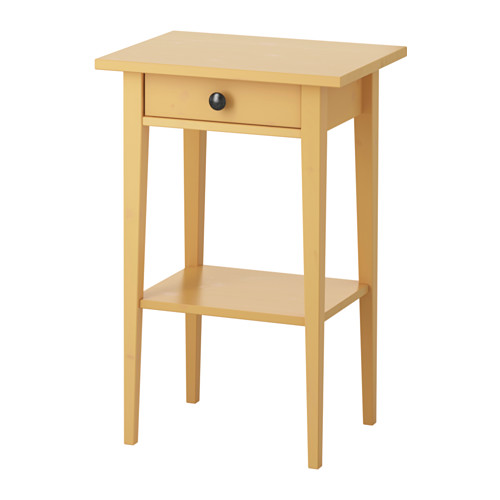

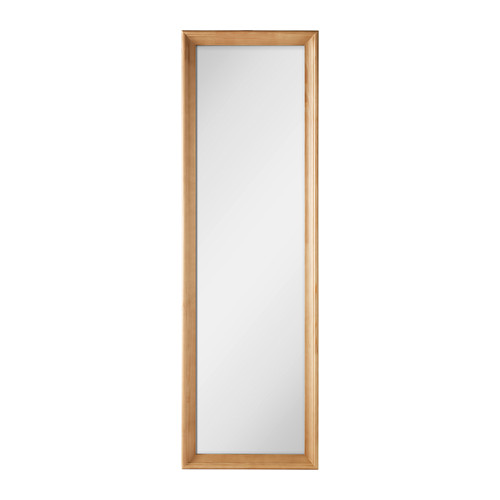

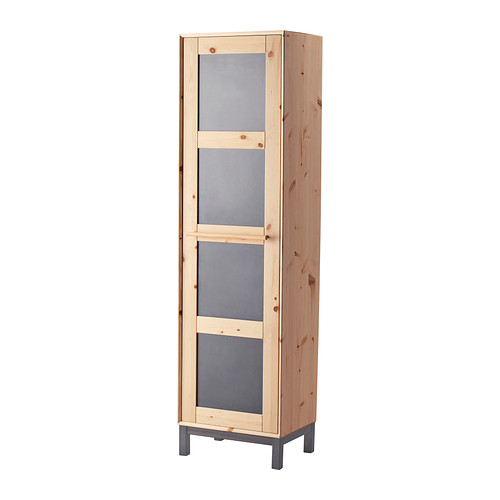

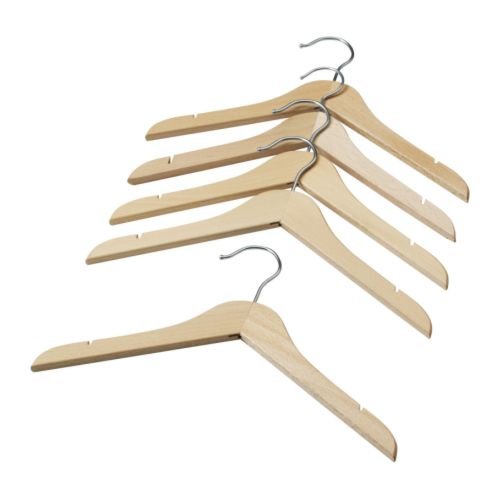

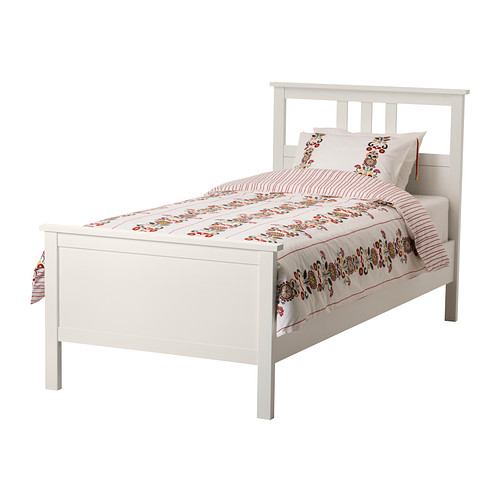

Most Similar Product:       ProductID                                        Description     Name  \
942  703.200.17  Made of solid wood, which is a hardwearing and...   HEMNES   
806  402.878.87  Made of solid wood, which is a hardwearing and...  STABEKK   
972  402.824.94  Made of solid wood, which is a hardwearing and...    NORNS   
143  601.787.69  Made of solid wood, which is a hardwearing and...     HNGA   
914  002.500.46  Made of solid wood, which is a hardwearing and...   HEMNES   

                       Type        Color             Size  \
942           Bedside table       Yellow           46x35    
806                  Mirror  Light brown          50x160    
972                Wardrobe    Pine,grey       56x44x202    
143  Children's coat-hanger      Natural              0x0   
914               Bed frame  White stain  Standard Single   

                                  Image  \
942  images/dining table/703.200.17.jpg   
806        images/mirror/402.878.87.jpg   
972    

In [18]:
input_string = 'Made from 100 cotton, a natural material that'
data_file='/Users/kabir/FRE-7773-Project/data/clean_data/product_embeddings.pkl'
similar_product, time_taken = text_matching(input_string, data_file)
print("Most Similar Product:", similar_product)
print("Time Taken:", time_taken, "seconds")